In [1]:
import sdv
print(sdv.__version__)
import pandas as pd
import commonfunc as common
import numpy as np

1.2.1


In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
patients_df = pd.read_csv("C:\\Users\\shrus\\Documents\\Synthetic-data-generation\\sampled_data_csv_100\\patients.csv")

In [4]:
def drop_row_id_column(data):
    if 'row_id' in data.columns:
        data.drop('row_id', axis=1, inplace=True)

In [5]:
drop_row_id_column(patients_df)


In [6]:
def changeObjectToDateTime(df,list):
    for i in list:
        df[i]=pd.to_datetime(df[i])

In [7]:
changeObjectToDateTime(patients_df,['dob','dod','dod_hosp','dod_ssn'])


In [8]:
admission_df = pd.read_csv("C:\\Users\\shrus\\Documents\\Synthetic-data-generation\\sampled_data_csv_100\\admissions.csv").loc[:, ['subject_id', 'admittime']]

In [9]:
patients_mid = pd.merge(left=patients_df, right=admission_df, how='inner', on=['subject_id'])

In [10]:
admission_df.drop_duplicates(subset=['subject_id'], keep='first', inplace=True)


In [11]:
changeObjectToDateTime(admission_df,['admittime'])

In [12]:
# Drop useless colums
patients_df.drop(['expire_flag', 'dod'], axis=1, inplace=True)

In [13]:
patients_df.isnull().sum()

subject_id     0
gender         0
dob            0
dod_hosp      80
dod_ssn       75
dtype: int64

In [14]:
patients_df.dtypes

subject_id             int64
gender                object
dob           datetime64[ns]
dod_hosp      datetime64[ns]
dod_ssn       datetime64[ns]
dtype: object

In [15]:
patients_df = pd.merge(left=patients_df, right=admission_df, how='inner', on=['subject_id'])

In [16]:
import datetime
import random

def adjust_age_over_90(df):
    years_100 = datetime.timedelta(days = (365 * 100 + 100/4))
    random_days_10_years = datetime.timedelta(days = random.randint(0, 10)*365)
    
    if (df['dob'] - datetime.datetime(1970,1,1)).total_seconds() < 0:
        return (df['admittime'] - years_100 + random_days_10_years)
    else:
        return df['dob']

In [17]:
patients_df['dob'] = patients_df.apply(adjust_age_over_90, axis=1)

In [18]:
# Calculate the age
def get_birth_delta(df):
    return df['admittime'] - df['dob']

# Randomly pick a time between 2001-2012
def adjust_admittime(df):
    return pd.Timestamp(year=random.randint(2001, 2012), \
        month=df['admittime'].month, day=df['admittime'].day)

# Renew the date of birth
def reset_dob(df):
    dob = df['admittime'] - df['dob']
    return pd.to_datetime(dob.date())

In [19]:
patients_df['dob'] = patients_df.apply(get_birth_delta, axis=1)
patients_df['admittime'] = patients_df.apply(adjust_admittime, axis=1)
patients_df['dob'] = patients_df.apply(reset_dob, axis=1)

In [20]:
patients_df.drop(['admittime'], axis=1, inplace=True)


In [21]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()

In [22]:
metadata.detect_from_dataframe(data=patients_df)

In [23]:
metadata

{
    "columns": {
        "subject_id": {
            "sdtype": "numerical"
        },
        "gender": {
            "sdtype": "categorical"
        },
        "dob": {
            "sdtype": "datetime"
        },
        "dod_hosp": {
            "sdtype": "datetime"
        },
        "dod_ssn": {
            "sdtype": "datetime"
        }
    },
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}

In [24]:
metadata.update_column(
    column_name='subject_id',
    sdtype='id',
    regex_format='[0-9]{3}'
)

In [25]:
metadata.set_primary_key(column_name='subject_id')

In [48]:
metadata.save_to_json(filepath='patients_metadata.json')

In [26]:
from sdv.lite import SingleTablePreset

synthesizer = SingleTablePreset(metadata, name='FAST_ML')
synthesizer.fit(patients_df)

synthetic_data = synthesizer.sample(num_rows=100)

In [55]:
from sdv.single_table import GaussianCopulaSynthesizer

synthesizer2 = GaussianCopulaSynthesizer(metadata)
synthesizer2.fit(patients_df)

synthetic_data2 = synthesizer2.sample(num_rows=100)

In [31]:
from sdv.single_table import CTGANSynthesizer

synthesizer3 = CTGANSynthesizer(metadata)
synthesizer3.fit(patients_df)

synthetic_data3 = synthesizer3.sample(num_rows=100)

In [34]:
from sdv.single_table import TVAESynthesizer

synthesizer4 = TVAESynthesizer(metadata)
synthesizer4.fit(patients_df)

synthetic_data4 = synthesizer4.sample(num_rows=100)

In [37]:
from sdv.single_table import CopulaGANSynthesizer

synthesizer5 = CopulaGANSynthesizer(metadata)
synthesizer5.fit(patients_df)

synthetic_data5 = synthesizer5.sample(num_rows=100)

In [46]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data=patients_df,
    synthetic_data=synthetic_data,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:00<00:00, 113.28it/s]


Overall Quality Score: 81.45%

Properties:
Column Shapes: 77.03%
Column Pair Trends: 85.88%


In [56]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data=patients_df,
    synthetic_data=synthetic_data2,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:00<00:00, 114.94it/s]


Overall Quality Score: 82.12%

Properties:
Column Shapes: 76.53%
Column Pair Trends: 87.71%


In [40]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data=patients_df,
    synthetic_data=synthetic_data3,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:00<00:00, 114.32it/s]


Overall Quality Score: 76.01%

Properties:
Column Shapes: 69.95%
Column Pair Trends: 82.08%


In [41]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data=patients_df,
    synthetic_data=synthetic_data4,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:00<00:00, 171.71it/s]


Overall Quality Score: 73.36%

Properties:
Column Shapes: 63.5%
Column Pair Trends: 83.23%


In [42]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data=patients_df,
    synthetic_data=synthetic_data5,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:00<00:00, 181.48it/s]


Overall Quality Score: 71.21%

Properties:
Column Shapes: 61.53%
Column Pair Trends: 80.89%


In [45]:
synthesizer2.save('C:\\Users\\shrus\\Documents\\Synthetic-data-generation\\models\\patients\\'+'patient_best_gaussiancopula.pkl')


In [47]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data=patients_df,
    synthetic_data=synthetic_data2,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:00<00:00, 90.81it/s]


Overall Quality Score: 82.12%

Properties:
Column Shapes: 76.53%
Column Pair Trends: 87.71%


In [57]:
quality_report.get_visualization('Column Shapes')

In [58]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=patients_df,
    synthetic_data=synthetic_data2,
    column_name='gender',
    metadata=metadata
)

fig.show()

array([<Axes: ylabel='gender'>], dtype=object)

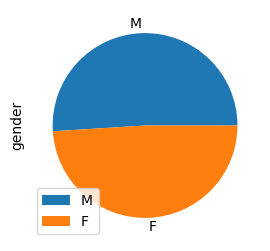

In [62]:

synthetic_data['gender'].value_counts().to_frame().plot.pie(subplots=True, figsize=(3,3))

array([<Axes: ylabel='gender'>], dtype=object)

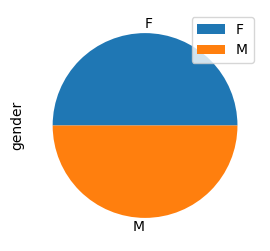

In [60]:
patients_df['gender'].value_counts().to_frame().plot.pie(subplots=True, figsize=(3,3))

In [63]:
quality_report.get_details(property_name='Column Shapes')

,Column,Metric,Quality Score
0,dob,KSComplement,0.850000
1,dod_hosp,KSComplement,0.493478
2,dod_ssn,KSComplement,0.747692
3,gender,TVComplement,0.970000


In [68]:
from sdmetrics.reports.single_table import DiagnosticReport

report = DiagnosticReport()

In [65]:
report.generate(patients_df, synthetic_data2, metadata)

Creating report: 100%|██████████| 4/4 [00:00<00:00,  9.33it/s]


DiagnosticResults:

SUCCESS:
✓ The synthetic data covers over 90% of the categories present in the real data
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data
